# Introduction: Exploratory Data Analysis

#### Although initial data cleaning and analysis is already done, in this section we will focus only on apartments for sale in Belgrade and some specifics of them.

In this jupyter notebook we will work only with data regarding flats for sale in the city of Belgrade. We will investigate and take the closer look into the data, clean it, try to detect patterns, correlations, check assumptions and do the visualization for some of the most interesting attributes on real estate properties.

# 1. Getting the data from database
## (only flats for sale in Belgrade)

In [1]:
# Importting libraries
import json
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Loading db connection parameters from json file
db_params = None
with open('../../database/db_connetion.json') as db_file:
    # Loading db connection parameters 
    db_params = json.load(db_file)

In [3]:
# Connecting to the database
conn = psycopg2.connect(
    host=db_params['host'], 
    port=db_params['port'], 
    database=db_params['database'], 
    user=db_params['user'], 
    password=db_params['password']
    )

In [4]:
# Getting the real estate data from database
# (only apartments for sale in Belgrade)
real_estate = pd.read_sql_query("""
    select * 
    from real_estate
    where location_city='beograd' 
    and listing_type='s'
    and property_type='a'
    """, conn)

In [5]:
# Sorting out correct name for city district in Belgrade
indexes_to_replace = real_estate[real_estate['location_city_district'] == 'novi beo'].index
real_estate.iloc[indexes_to_replace,:]

for index in indexes_to_replace:
    real_estate.at[index, 'location_city_district'] = 'novi beograd'

# 2. Removing real estate entries

## 2.1. Removing unnecessary columns

Removing columns which are not goind to be beneficial to us for next steps when it comes to the modeling. Columns that will be removed are:
- id: internam id number from database
- listing_type: flat stating if the real estate is for sale or for rent 
- property_type: flat stating if the listed real estate is a flat or a house 
- area_land: area of the land (only from houses)
- source: url from real estate website from which data was scraped

In [6]:
# Removing unnecessary columns
real_estate = real_estate.drop(labels=['id', 'listing_type', 'property_type','area_land', 'source'], axis=1)

In [7]:
real_estate.describe()

,price,area_property,num_floors_building,apartment_floor,num_rooms,num_bathrooms
count,3.769000e+03,3769.000000,3106.000000,3686.000000,3765.000000,3769.000000
mean,1.387060e+05,73.794375,5.781069,3.371134,2.649270,1.069514
std,1.290707e+05,43.008972,4.206931,5.956885,1.030114,0.309006
min,1.150000e+04,12.000000,1.000000,-1.000000,1.000000,1.000000
25%,6.824400e+04,50.000000,3.250000,1.000000,2.000000,1.000000
50%,1.069500e+05,66.000000,5.000000,2.000000,2.500000,1.000000
75%,1.690000e+05,88.000000,6.750000,4.000000,3.000000,1.000000
max,2.500000e+06,966.000000,30.000000,100.000000,8.000000,6.000000


## 2.2. Removing real estate properties without any city district name

For building our model, it is really important for us to know in which municipality real estete is located. Thah's the reason why we're removing those entries, because we wouldn't know how to fill those missing values

In [8]:
real_estate[real_estate['location_city_district'].isna()]

,price,location_city,location_city_district,area_property,construction_type,num_floors_building,apartment_floor,registered,heating_type,num_rooms,num_bathrooms
126,125000.0,beograd,None,90.0,2017,6.0,4.0,True,Etažno,4.0,1.0
136,149900.0,beograd,None,92.0,2016,8.0,3.0,True,Gas,3.5,1.0
148,63500.0,beograd,None,50.0,None,4.0,0.0,True,Etažno,2.5,1.0
504,120000.0,beograd,None,68.0,None,20.0,4.0,True,Centralno,3.0,1.0
729,89000.0,beograd,None,72.0,None,3.0,0.0,True,Etažno,3.5,1.0
1270,30000.0,beograd,None,51.0,None,6.0,5.0,True,None,2.0,1.0
1443,115000.0,beograd,None,61.0,None,8.0,2.0,True,Centralno,2.5,1.0
1924,68000.0,beograd,None,44.0,None,6.0,1.0,True,Gas,2.0,1.0
2005,33000.0,beograd,None,41.0,2004,2.0,0.0,True,Etažno,2.0,1.0
2255,135000.0,beograd,None,78.0,1976,11.0,7.0,True,Centralno,3.5,1.0


In [9]:
# Removing real estate with city district name
indexes_to_remove = real_estate[real_estate['location_city_district'].isna()].index
real_estate = real_estate.drop(labels=indexes_to_remove, axis=0)

# 3. Handling missing values

## 3.1. Listing all city districts in Belgrade

In [10]:
# Listing all city districts in Belgrade
real_estate['location_city_district'].unique()

array(['stari grad', 'zvezdara', 'vracar', 'palilula', 'novi beograd',
       'cukarica', 'savski venac', 'zemun', 'rakovica', 'vozdovac',
       'mladenovac', 'grocka', 'lazarevac', 'obrenovac', 'surcin',
       'barajevo'], dtype=object)

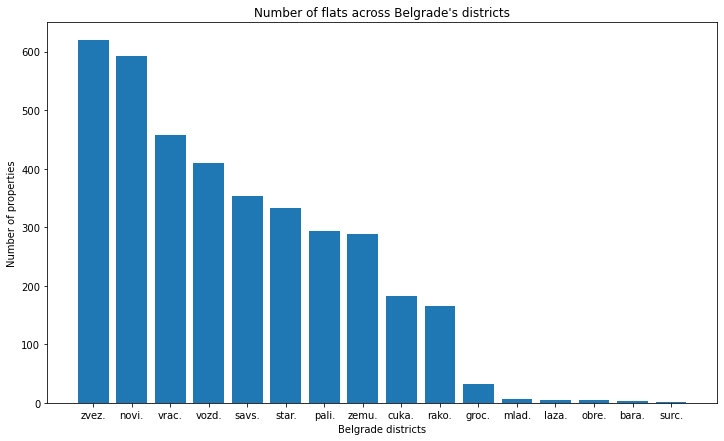

In [11]:
# Selecting only properties in Belgrade and grouping them by city district 
city_districts = real_estate.groupby(['location_city_district']).count().sort_values('price', ascending=False).head(50)

# Plotting Belgrade's districts and number of listed properties for sale in them
plt.figure(figsize=(12, 7)) 
plt.bar(list(map(lambda city_name:city_name[:4] + '.', city_districts.index)), city_districts['price'])
plt.title("Number of flats across Belgrade's districts")
plt.xlabel('Belgrade districts')
plt.ylabel('Number of properties')
plt.show()

## 3.2. Flat size: handling missing values  

In [12]:
real_estate[real_estate['area_property'].isna()]

,price,location_city,location_city_district,area_property,construction_type,num_floors_building,apartment_floor,registered,heating_type,num_rooms,num_bathrooms


## 3.3. Flat's year of construction: handling missing values 

In [13]:
real_estate[real_estate['construction_type'].isna()]

,price,location_city,location_city_district,area_property,construction_type,num_floors_building,apartment_floor,registered,heating_type,num_rooms,num_bathrooms
9,83000.0,beograd,cukarica,77.0,None,8.0,7.0,True,None,2.5,1.0
11,92000.0,beograd,savski venac,67.0,None,3.0,3.0,True,Norveški radijatori,2.5,1.0
12,250000.0,beograd,vracar,73.0,None,3.0,3.0,True,Centralno,3.0,1.0
13,45000.0,beograd,stari grad,22.0,None,4.0,0.0,True,Struja,1.0,1.0
14,30000.0,beograd,zemun,38.0,None,1.0,1.0,True,Struja,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
3762,67300.0,beograd,rakovica,60.0,None,5.0,5.0,True,Etažno,3.0,1.0
3764,43200.0,beograd,grocka,48.0,None,2.0,0.0,True,Struja,3.0,1.0
3765,101000.0,beograd,novi beograd,55.0,None,15.0,15.0,True,Centralno,2.5,1.0
3766,37700.0,beograd,zemun,29.0,None,NaN,NaN,False,None,1.0,1.0


Number of real estate with missing info on year of construction: 2260
Number of real estate with existing info on year of construction: 1489


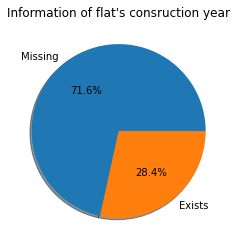

In [14]:
# Looking at the statistics of column that hold real estate's year of construction

missing_values = real_estate['construction_type'].isna().sum()
total_number = real_estate.shape[0]
print(f'Number of real estate with missing info on year of construction: {missing_values}')
print(f'Number of real estate with existing info on year of construction: {total_number - missing_values}')


plt.pie([total_number, (total_number - missing_values)], labels=['Missing', 'Exists'], autopct='%1.1f%%', shadow=True)
plt.title('Information of flat\'s consruction year')
plt.show()

#### More than 50% column values are null, we cannot fill those missing values.
#### Instead, we will entrirely remove the column.

In [15]:
real_estate = real_estate.drop(labels=['construction_type'], axis=1)

## 3.4. Flat's floor number: handling missing values 

In this section we will be looking at two columns:
- apartment_floor: number of floor in the building on whic the flat is located 
- num_floors_building: total number of the floors in the building

`apartment_floor` can have some special values:
- 100: that value signifies that the apartment is in attic
- 0: that value signifies that the apartment is on ground floor
- -1: that value signifies that the apetment is in basement

### 3.4.1. Floor number distribution

In [16]:
real_estate = real_estate.reset_index(drop=True)

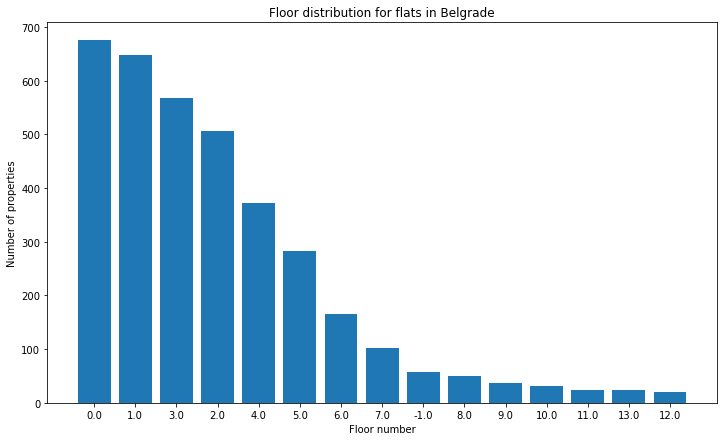

In [17]:
# Grouping flats by their floor number in the building 
floor_distribution = real_estate.groupby(['apartment_floor']).count().sort_values('price', ascending=False).head(15)

# Plotting floor distribution for flats in Belgrade
plt.figure(figsize=(12, 7)) 
plt.bar(floor_distribution.index.astype(str), floor_distribution['price'])
plt.title("Floor distribution for flats in Belgrade")
plt.xlabel('Floor number')
plt.ylabel('Number of properties')
plt.show()

### 3.4.2. Updating floor number for flats in the attic

#### For the floor in the attic instead of value 100, we'll be using the last (top) floor of the building. 

In [18]:
# Attic - change it to the last floor
indexes_to_replace = real_estate[real_estate['apartment_floor']==100].index
real_estate.iloc[indexes_to_replace]

,price,location_city,location_city_district,area_property,num_floors_building,apartment_floor,registered,heating_type,num_rooms,num_bathrooms
81,89000.0,beograd,stari grad,43.0,2.0,100.0,True,Struja,1.0,1.0
323,43000.0,beograd,palilula,52.0,NaN,100.0,True,Struja,2.0,1.0
2256,80000.0,beograd,zemun,88.0,6.0,100.0,True,Centralno,2.5,1.0
2341,231000.0,beograd,vracar,92.0,4.0,100.0,True,Centralno,3.0,1.0
2342,224400.0,beograd,vracar,89.0,4.0,100.0,True,Centralno,3.0,1.0
3140,19000.0,beograd,zemun,49.0,NaN,100.0,False,None,1.5,1.0
3380,90000.0,beograd,savski venac,93.0,2.0,100.0,True,Struja,3.5,1.0
3401,377000.0,beograd,savski venac,145.0,2.0,100.0,True,None,4.0,1.0
3511,41500.0,beograd,rakovica,52.0,1.0,100.0,True,TA peć,2.0,1.0


In [19]:
print(f'Updating apartment_floor for {len(indexes_to_replace)} real estate that are on attic.')
for index in indexes_to_replace:
    if not pd.isna(real_estate.iloc[index,:]['num_floors_building']):
        real_estate.at[index, 'apartment_floor'] = real_estate.iloc[index,:]['num_floors_building']

Updating apartment_floor for 9 real estate that are on attic.


In [20]:
# Removing remaining onces
indexes_to_remove = real_estate[real_estate['apartment_floor']==100].index
real_estate = real_estate.drop(labels=indexes_to_remove, axis=0)

In [21]:
# Reindexing our dataset
real_estate = real_estate.reset_index(drop=True)

### 3.4.2. Updating floor number for missing values

#### Now, we'll be populating the missing values in `apartment_floor` and `num_floors_building` columns. For those values we will use the floor number which is the most common floor number in the municipality that they are located in.

In [22]:
# Getting the indexes for missing apartment and building floors.  
indexes_to_update_1 = real_estate[real_estate['num_floors_building'].isna() & real_estate['apartment_floor'].isna()].index
indexes_to_update_2 = real_estate[real_estate['apartment_floor'].isna()].index
indexes_to_update_3 = real_estate[real_estate['num_floors_building'].isna()].index

# Getting the number of missing apartment and building floors. 
no_building_and_flat_num = real_estate[real_estate['num_floors_building'].isna() & real_estate['apartment_floor'].isna()].shape[0]
no_flat_num = real_estate[real_estate['apartment_floor'].isna()].shape[0]
no_bulding_num = real_estate[real_estate['num_floors_building'].isna()].shape[0]

print('Number of apertments without:')
print(f'\t 1. Both the information about flat floor and number of floors in the bulding: {no_building_and_flat_num}')
print(f'\t 1. Information about flat floor: {no_flat_num}')
print(f'\t 1. Information about number of floors in the bulding: {no_bulding_num}')

Number of apertments without:
	 1. Both the information about flat floor and number of floors in the bulding: 82
	 1. Information about flat floor: 82
	 1. Information about number of floors in the bulding: 659


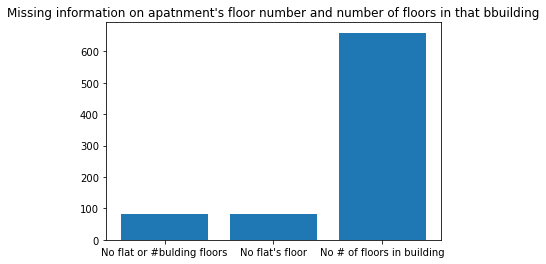

In [23]:
# Plotting the missing information on the floor numbers
plt.bar(
    ['No flat or #bulding floors', 'No flat\'s floor', 'No # of floors in building'], 
    [no_building_and_flat_num, no_flat_num, no_bulding_num])
plt.title('Missing information on apatnment\'s floor number and number of floors in that bbuilding')
plt.show()

In [24]:
# Calculating the mean for the all columns, for each municipality separately
mean_values_by_city_districts = real_estate.groupby(['location_city_district']).mean()
mean_values_by_city_districts

,price,area_property,num_floors_building,apartment_floor,registered,num_rooms,num_bathrooms
location_city_district,,,,,,,
barajevo,31333.333333,62.333333,4.000000,2.000000,0.666667,2.166667,1.000000
cukarica,106696.617486,73.409836,4.477707,2.252747,0.890710,2.631148,1.054645
grocka,44194.687500,57.875000,3.200000,1.250000,0.968750,2.234375,1.093750
lazarevac,46875.000000,65.250000,3.500000,3.000000,1.000000,2.500000,1.000000
mladenovac,41071.428571,65.571429,4.500000,2.571429,0.857143,2.642857,1.285714
novi beograd,128828.473862,70.694772,9.022133,5.147513,0.934233,2.539629,1.065767
obrenovac,53250.000000,63.000000,5.333333,2.000000,0.500000,2.250000,1.000000
palilula,89778.218430,64.423208,4.804688,2.375000,0.883959,2.440068,1.034130
rakovica,67331.602410,71.144578,4.593103,2.426829,0.891566,2.554217,1.060241


In [25]:
# Using municipality mean value for "apartment_floor" column to fill missing info
print(f'Updating apartment_floor information for {len(indexes_to_update_2)} real estate prperties.')

for index in indexes_to_update_2:
    city_district = real_estate.iloc[index,:]['location_city_district'] 
    real_estate.at[index, 'apartment_floor'] = mean_values_by_city_districts.loc[city_district]['apartment_floor']

Updating apartment_floor information for 82 real estate prperties.


In [26]:
# Using municipality mean value for "num_floors_building" column to fill missing info
print(f'Updating num_floors_building information for {len(indexes_to_update_3)} real estate prperties.')

for index in indexes_to_update_3:
    city_district = real_estate.iloc[index,:]['location_city_district'] 
    real_estate.at[index, 'num_floors_building'] = mean_values_by_city_districts.loc[city_district]['num_floors_building']

Updating num_floors_building information for 659 real estate prperties.


## 3.5. Number of rooms: handling missing values 


In [27]:
# Listing all real estate properties that don't have room number information
real_estate[real_estate['num_rooms'].isna()]

,price,location_city,location_city_district,area_property,num_floors_building,apartment_floor,registered,heating_type,num_rooms,num_bathrooms
356,127000.0,beograd,palilula,90.0,5.0,4.0,True,Etažno,NaN,1.0
1623,49000.0,beograd,vozdovac,47.0,3.0,0.0,True,None,NaN,1.0
2058,27000.0,beograd,stari grad,17.0,6.0,0.0,True,Centralno,NaN,1.0
3675,700000.0,beograd,savski venac,275.0,2.0,0.0,True,Etažno,NaN,1.0


In [28]:
# Using average room number to fill that missing information
for index in real_estate[real_estate['num_rooms'].isna()].index:
    real_estate.at[index, 'num_rooms'] = real_estate['num_rooms'].mean()

## 3.6. Heating type: handling missing values 

In [29]:
# Getting the real estate properties that don't have heating information
indexes_to_replace = real_estate[real_estate['heating_type'].isna()].index
real_estate.iloc[indexes_to_replace, :]

,price,location_city,location_city_district,area_property,num_floors_building,apartment_floor,registered,heating_type,num_rooms,num_bathrooms
9,83000.0,beograd,cukarica,77.0,8.000000,7.000000,True,None,2.5,1.0
22,98000.0,beograd,savski venac,46.0,7.000000,5.000000,True,None,2.0,1.0
84,120800.0,beograd,novi beograd,46.0,9.022133,10.000000,True,None,2.0,1.0
106,110000.0,beograd,savski venac,60.0,3.000000,3.000000,True,None,3.0,1.0
116,350000.0,beograd,vozdovac,112.0,4.000000,1.000000,True,None,4.0,1.0
...,...,...,...,...,...,...,...,...,...,...
3595,39000.0,beograd,rakovica,33.0,6.000000,0.000000,True,None,1.0,1.0
3626,133180.0,beograd,cukarica,67.0,5.000000,4.000000,True,None,3.0,1.0
3651,28900.0,beograd,vracar,30.0,4.910761,0.000000,True,None,1.0,1.0
3677,60000.0,beograd,vozdovac,42.0,5.749245,0.000000,True,None,1.5,1.0


In [30]:
# Calculating number of aperments for each heating type in each municipality
heating_types_by_districts = real_estate.groupby(['location_city_district', 'heating_type']).count()
heating_types_by_districts

price  location_city  \
location_city_district heating_type                                
barajevo               Centralno                2              2   
cukarica               Centralno              103            103   
                       Etažno                  31             31   
                       Gas                     10             10   
                       Norveški radijatori      1              1   
...                                           ...            ...   
zvezdara               Kaljeva peć              1              1   
                       Norveški radijatori     26             26   
                       Podno                   13             13   
                       Struja                  41             41   
                       TA peć                  23             23   

                                            area_property  \
location_city_district heating_type                         
barajevo               Centralno                        2   
cukarica               Centralno                      103   
                       Etažno                          31   
                       Gas                             10   
                       Norveški radijatori              1   
...                                                   ...   
zvezdara               Kaljeva peć                      1   
                       Norveški radijatori             26   
                       Podno                           13   
                       Struja                          41   
                       TA peć                          23   

                                            num_floors_building  \
location_city_district heating_type                               
barajevo               Centralno                              2   
cukarica               Centralno                            103   
                       Etažno                                31   
                       Gas                                   10   
                       Norveški radijatori                    1   
...                                                         ...   
zvezdara               Kaljeva peć                            1   
                       Norveški radijatori                   26   
                       Podno                                 13   
                       Struja                                41   
                       TA peć                                23   

                                            apartment_floor  registered  \
location_city_district heating_type                                       
barajevo               Centralno                          2           2   
cukarica               Centralno                        103         103   
                       Etažno                            31          31   
                       Gas                               10          10   
                       Norveški radijatori                1           1   
...                                                     ...         ...   
zvezdara               Kaljeva peć                        1           1   
                       Norveški radijatori               26          26   
                       Podno                             13          13   
                       Struja                            41          41   
                       TA peć                            23          23   

                                            num_rooms  num_bathrooms  
location_city_district heating_type                                   
barajevo               Centralno                    2              2  
cukarica               Centralno                  103            103  
                       Etažno                      31             31  
                       Gas                         10             10  
                       Norveški radijatori          1              1  
...                 

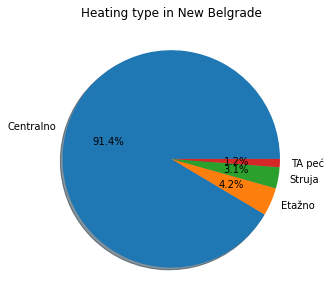

In [31]:
# Example: plotting all heating types for municipality of new Belgrade
labels = []
values = []

# Getting all the heating types and the number of apartments using it
district_heating = heating_types_by_districts.loc['novi beograd']
for heating_type in district_heating.index:
    if float(district_heating.loc[heating_type]['price']) > 5:
        labels.append(heating_type)
        values.append(district_heating.loc[heating_type]['price'])

# Plotting the heating type values
plt.figure(figsize=(10, 5)) 
plt.tight_layout()
plt.pie(values, labels=labels, autopct='%1.1f%%', shadow=True)
plt.title('Heating type in New Belgrade')
plt.show()

In [32]:
def city_district_most_used_heating_mapping(heating_types_by_districts):
    mapping = dict()
    
    # All city districts
    city_districts = real_estate['location_city_district'].unique()
    
    # Finding the most used mapping type in each city district
    for city_district in city_districts:
        max_heating_type = heating_types_by_districts.loc[city_district][heating_types_by_districts.loc[city_district]['price'] == heating_types_by_districts.loc[city_district]['price'].max()].index
        mapping[city_district] = max_heating_type[0]
    
    return mapping

In [33]:
district_heating_type_mapping = city_district_most_used_heating_mapping(heating_types_by_districts)
district_heating_type_mapping

{'stari grad': 'Centralno',
 'zvezdara': 'Centralno',
 'vracar': 'Centralno',
 'palilula': 'Centralno',
 'novi beograd': 'Centralno',
 'cukarica': 'Centralno',
 'savski venac': 'Centralno',
 'zemun': 'Etažno',
 'rakovica': 'Centralno',
 'vozdovac': 'Centralno',
 'mladenovac': 'Gas',
 'grocka': 'Etažno',
 'lazarevac': 'Centralno',
 'obrenovac': 'Centralno',
 'surcin': 'TA peć',
 'barajevo': 'Centralno'}

In [34]:
print(f'Updating {len(indexes_to_replace)} real estate properties and their heating types.')
for index in indexes_to_replace:
    city_district = real_estate.iloc[index, :]['location_city_district']
    most_probable_heating_type = district_heating_type_mapping[city_district]
    real_estate.at[index, 'heating_type'] = most_probable_heating_type 

Updating 255 real estate properties and their heating types.


# 4. Looking at the relationships between columns

In [35]:
# Importing seaborn library for visualization purposes
import seaborn as sns

## 4.1. Flat's price and size

#### Based on the scatterplot of the apartment price and size, we can clearly see the outliers, that will potentially cause our model to perform bad.


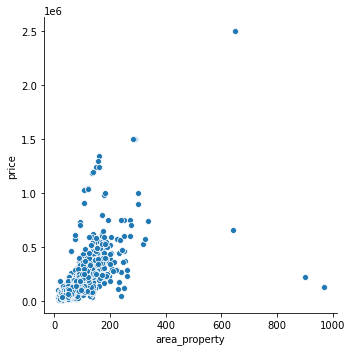

In [36]:
sns.relplot(x='area_property', 
            y='price',
            data=real_estate);

In [37]:
# Outlier based on the flat size
indexes_to_remove = real_estate[real_estate['area_property']>600].index
real_estate.iloc[indexes_to_remove, :]

,price,location_city,location_city_district,area_property,num_floors_building,apartment_floor,registered,heating_type,num_rooms,num_bathrooms
158,133980.0,beograd,zvezdara,966.0,7.000000,1.000000,True,Centralno,3.0,1.0
1304,659000.0,beograd,vozdovac,640.0,9.000000,8.000000,True,Etažno,5.0,1.0
2018,220000.0,beograd,rakovica,900.0,4.593103,3.000000,True,Centralno,6.5,3.0
2912,2500000.0,beograd,savski venac,650.0,7.822314,5.060694,False,Centralno,5.0,1.0


In [38]:
# Removing flat size outliers
real_estate = real_estate.drop(labels=indexes_to_remove, axis=0)

In [39]:
# Reindexing our dataset
real_estate = real_estate.reset_index(drop=True)

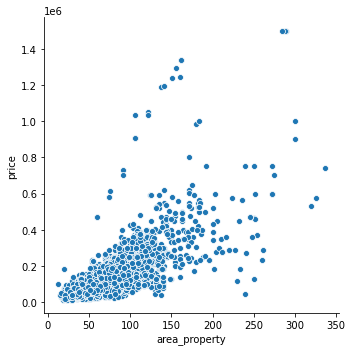

In [40]:
# Plotting again after removing the problematic entries
sns.relplot(x='area_property', 
            y='price',
            data=real_estate);

## 4.2. Flat's size and price across municipalities

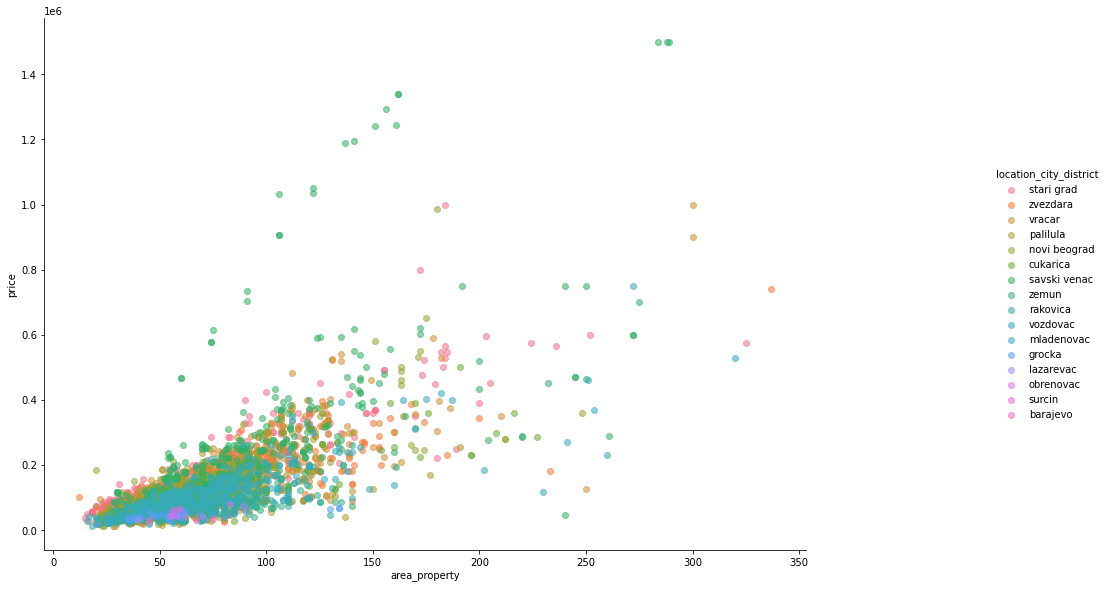

In [41]:
# Coloring data points based on the city district (categorical variable) 
municipalities_scatter = sns.lmplot( 
    x="area_property", 
    y="price", 
    data=real_estate, 
    fit_reg=False, 
    hue='location_city_district', 
    legend=True,  
    scatter_kws={'alpha':0.55}
    )
municipalities_scatter.fig.set_size_inches(17, 9)

## 4.3. Pairwise numerical relationships and distibution functions

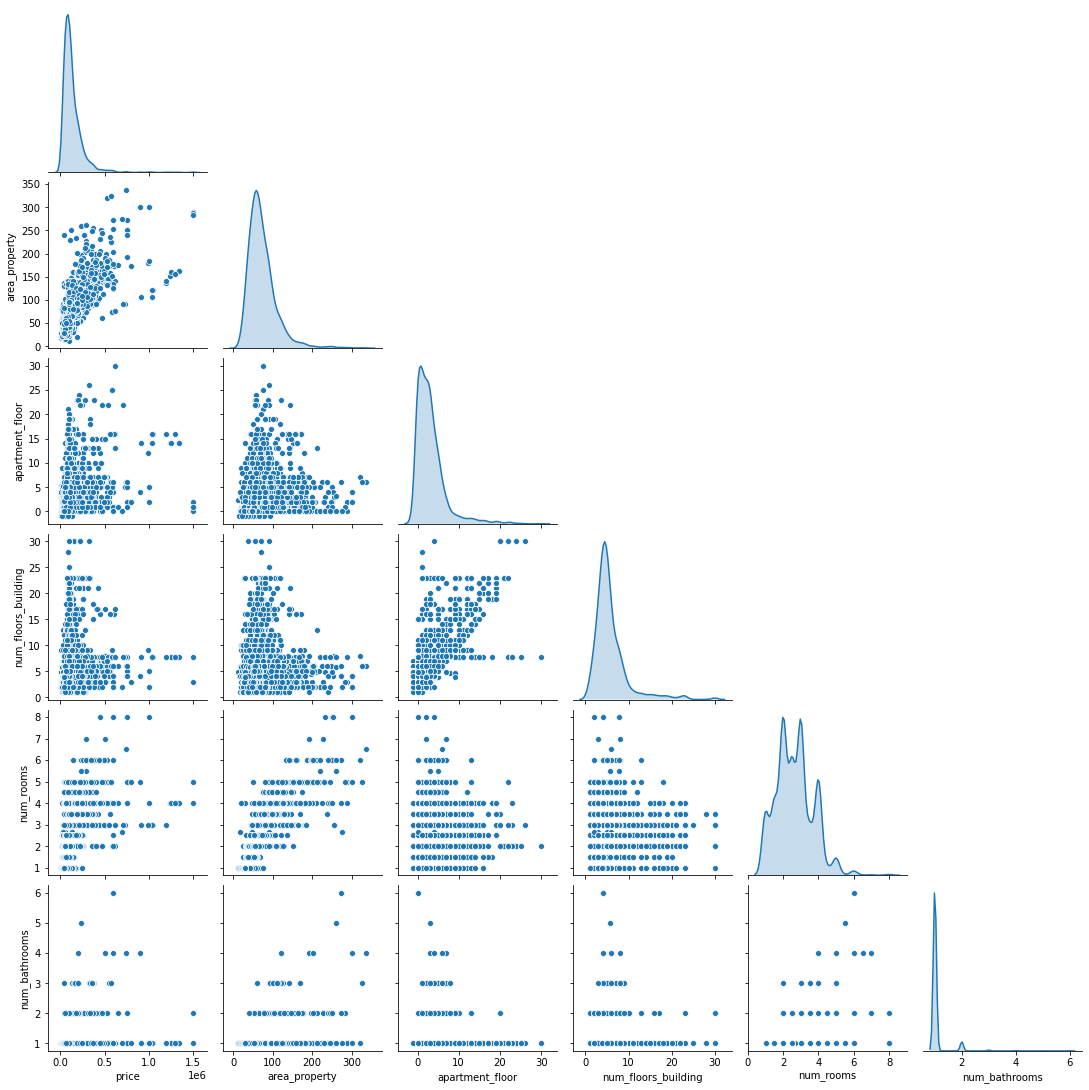

In [42]:
sns.pairplot(
    real_estate[['price','area_property','apartment_floor', 'num_floors_building', 'num_rooms','num_bathrooms']],
    corner=True,
    diag_kind="kde"
)

## 4.4. Correlations between columns

From the correlation matrix we can see that there is clearly high correlation between:
- `flat price` and `flat size`
- `flat price` and `number of rooms`

What is also interesting is that `apartment floor` is more correlated to the selling price than the `total number of the floors ` in the building is. 

Additional thing that was expected is that `aparment size` and `number of rooms` are also highly correlated.

In [43]:
# Correlations matrix
real_estate[['price','area_property','apartment_floor', 'num_floors_building', 'num_rooms','num_bathrooms']].corr()

,price,area_property,apartment_floor,num_floors_building,num_rooms,num_bathrooms
price,1.000000,0.719100,0.248875,0.094109,0.519557,0.215186
area_property,0.719100,1.000000,0.124619,0.000022,0.805271,0.320945
apartment_floor,0.248875,0.124619,1.000000,0.626525,0.100044,0.011437
num_floors_building,0.094109,0.000022,0.626525,1.000000,-0.024822,-0.020245
num_rooms,0.519557,0.805271,0.100044,-0.024822,1.000000,0.268235
num_bathrooms,0.215186,0.320945,0.011437,-0.020245,0.268235,1.000000


<AxesSubplot:>

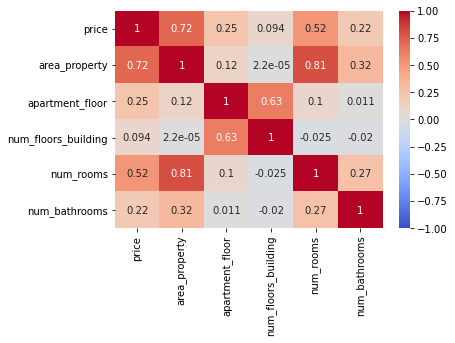

In [44]:
# Correlation matrix represented as heatmap for better visualization
sns.heatmap(
    real_estate[['price','area_property','apartment_floor','num_floors_building', 'num_rooms','num_bathrooms']].corr(), 
    annot = True, 
    vmin=-1, 
    vmax=1, 
    center= 0, 
    cmap= 'coolwarm'
)

# 5. Saving the processed dataset

In [45]:
# Saving results to the csv file
real_estate.to_csv('../../database/backup/belgrade_flats.csv',index=False)